In [9]:
import pandas as pd
from datetime import date
from datetime import time
from pyproj import Proj, transform
from tqdm import tqdm
import altair as alt
import warnings
warnings.filterwarnings('ignore')
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Data Cleaning and Preparation

In [2]:
df = pd.read_csv('out2.csv')

In [3]:
df.head()

,Unnamed: 0,Ticket number,Issue Date,Issue time,RP State Plate,Plate Expiry Date,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,year
0,0,4320468924,2018-01-13T00:00:00,26.0,CA,201801.0,MERZ,PA,BL,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,2018
1,1,4320468935,2018-01-13T00:00:00,27.0,CA,201801.0,MERZ,PA,BL,5033 LINCOLN AVE,00611,56.0,5200,DISPLAY OF PLATES,25.0,6.499186e+06,1.866284e+06,2018
2,2,4320468946,2018-01-13T00:00:00,27.0,CA,201804.0,FORD,PA,SL,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,2018
3,3,4320468950,2018-01-13T00:00:00,28.0,CA,201812.0,FORD,PA,BL,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,2018
4,4,4320468961,2018-01-13T00:00:00,29.0,CA,201806.0,TOYT,PA,BK,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,2018


In [4]:
col_to_move = [df.columns[0]] + df.columns[4:9].to_list() + [df.columns[-1]]
data = df.drop(col_to_move, axis=1)

In [5]:
def clean_the_code(some_code):
    return some_code.replace(".", "").replace("*", "").replace("+", "")

data['Issue Date'] = pd.to_datetime(data['Issue Date'])
data['clean_v_code'] = data['Violation code'].map(clean_the_code)
data['month'] = data['Issue Date'].map(lambda x: x.month)

In [101]:
agency = pd.read_csv('agency code.csv')
angency_dic = dict(zip(agency['AGENCY CODE'],agency['AGENCY NAME']))
data['Angency Name'] = data['Agency'].map(lambda x: angency_dic.get(x))
data.head()

,Ticket number,Issue Date,Issue time,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,clean_v_code,month,Angency Name
0,4320468924,2018-01-13,26.0,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,8069B,1,56 - DOT - CENTRAL
1,4320468935,2018-01-13,27.0,5033 LINCOLN AVE,00611,56.0,5200,DISPLAY OF PLATES,25.0,6.499186e+06,1.866284e+06,5200,1,56 - DOT - CENTRAL
2,4320468946,2018-01-13,27.0,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,8069B,1,56 - DOT - CENTRAL
3,4320468950,2018-01-13,28.0,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,8069B,1,56 - DOT - CENTRAL
4,4320468961,2018-01-13,29.0,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,8069B,1,56 - DOT - CENTRAL


In [6]:
Violation_mapping = data.groupby('clean_v_code')['Violation Description']\
            .apply(lambda x: set(list(x)))\
            .to_frame().reset_index()
Violation_mapping['unique_desc'] = Violation_mapping['Violation Description'].map(lambda x: len(x))
print(Violation_mapping['unique_desc'].value_counts())
Violation_dict = dict(zip(Violation_mapping.clean_v_code, Violation_mapping['Violation Description']))

1      161
2       26
4        3
218      1
3        1
Name: unique_desc, dtype: int64


# Citation Fine Total Dollar Amount Analysis

In 2018, \\$140,372,757 in fines were issued. During the year,the month of March had the highest amount issued with over \\$13,543,000 issued and September was the lowest with \\$9.9 million issued. There was a noticeable trend downward as the year went on, with the lower amount volumes coming at the end of the year.

In [7]:
total_fine = data['Fine amount'].sum()
avg_fine = data['Fine amount'].mean()
print(f'Total issued tickets in 2018: {data.shape[0]}')
print(f'Total fines in 2018: {total_fine}')
print(f'Average fines in 2018: {avg_fine}')
data.head()

Total issued tickets in 2018: 1997938
Total fines in 2018: 140372757.0
Average fines in 2018: 70.31685141780574


,Ticket number,Issue Date,Issue time,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,clean_v_code,month
0,4320468924,2018-01-13,26.0,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,8069B,1
1,4320468935,2018-01-13,27.0,5033 LINCOLN AVE,00611,56.0,5200,DISPLAY OF PLATES,25.0,6.499186e+06,1.866284e+06,5200,1
2,4320468946,2018-01-13,27.0,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,8069B,1
3,4320468950,2018-01-13,28.0,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,8069B,1
4,4320468961,2018-01-13,29.0,5033 LINCOLN AVE,00611,56.0,80.69B,NO PARKING,73.0,6.499186e+06,1.866284e+06,8069B,1


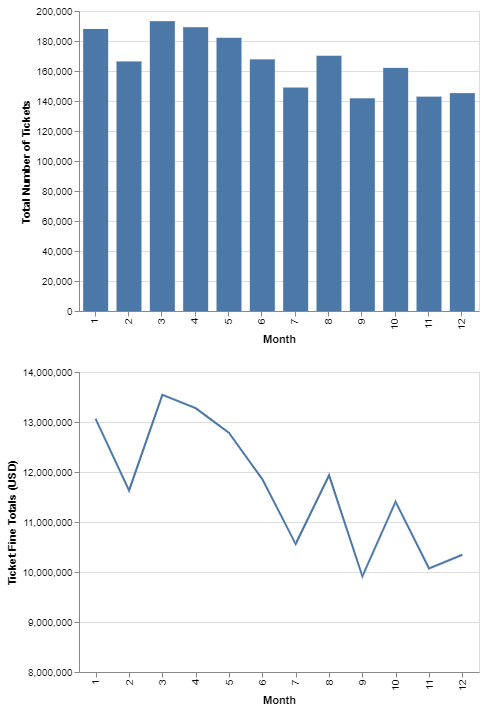

In [21]:
chart1 = data.groupby('month').agg({'Ticket number': 'count'}).reset_index()
chart2 = data.groupby('month').agg({'Fine amount': 'sum'}).reset_index()

ticket_total_number = alt.Chart(chart1).mark_bar(size=25).encode(
                        alt.X('month',type='ordinal',title='Month'),
                        alt.Y('Ticket number',type='quantitative',title='Total Number of Tickets'),)\
                        .properties(width=400)

yscale = alt.Scale(domain=(8000000, 14000000))
total_fine = alt.Chart(chart2).mark_line().encode(
                       alt.X('month',type='ordinal',title='Month'),
                       alt.Y('Fine amount', type='quantitative', scale=yscale,title='Ticket Fine Totals (USD)'),)\
                       .properties(width=400)
ticket_total_number & total_fine

# Hourly Violation Analysis
The first graph shows a drastic jump in issued tickets starting at 8am and lasting throughout noon, wherafter the number of citations start to decrease. Most of the citations were issued at 8am, 10am, and noon. The top 5 violations for each hour were also shown in the second graph, which allows us to find some correlations between violation types and hours, for instance, "NO PARK/STREET CLEAN" violation happened most frequently around 8am to 1pm.

In [22]:
filtered_df = data[data['Issue time'].notnull()]
filtered_df['Issue time'] = filtered_df['Issue time'].apply(lambda x: str(int(x)).zfill(4))
filtered_df['Issue time'] = filtered_df['Issue time'].map(lambda x: str(x)[:-2])

In [23]:
chart3 = filtered_df.groupby("Issue time").agg({"Ticket number":"count",'Fine amount': 'sum'}).reset_index()
chart3

,Issue time,Ticket number,Fine amount
0,00,21249,1480836.0
1,01,47711,3456814.0
2,02,47066,3393679.0
3,03,29600,2118726.0
4,04,27531,1994798.0
5,05,19184,1413322.0
6,06,30063,2107823.0
7,07,46328,3863246.0
8,08,257535,18125686.0
9,09,130670,9089245.0


In [24]:
temp = filtered_df.groupby(["Issue time",'clean_v_code']).agg({"Ticket number":"count"}).reset_index()
chart4 = temp.groupby('Issue time').apply(lambda dfg: dfg.nlargest(5,'Ticket number')).reset_index(drop=True)

def get_violation_desc(row):
    desc = Violation_dict[row]
    for d in desc:
        return d
        break 
chart4['violation_description'] = chart4['clean_v_code'].map(get_violation_desc)

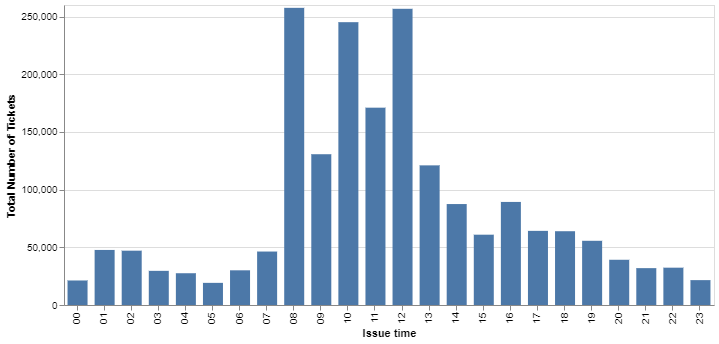

In [52]:
ticket_total_number_hourly = alt.Chart(chart3).mark_bar(size=20).encode(
                        alt.X('Issue time',type='ordinal'),
                        alt.Y('Ticket number',type='quantitative',title='Total Number of Tickets'),)\
                        .properties(width=650)

# ticket_total_number_hourly = base.encode(
#     alt.X(field='Issue time', type='ordinal',title='Hour of Day',
#           sort=alt.EncodingSortField(field='Ticket number'))
# ).properties(title='Total Number of Tickets by Hour of Day')

ticket_total_number_hourly

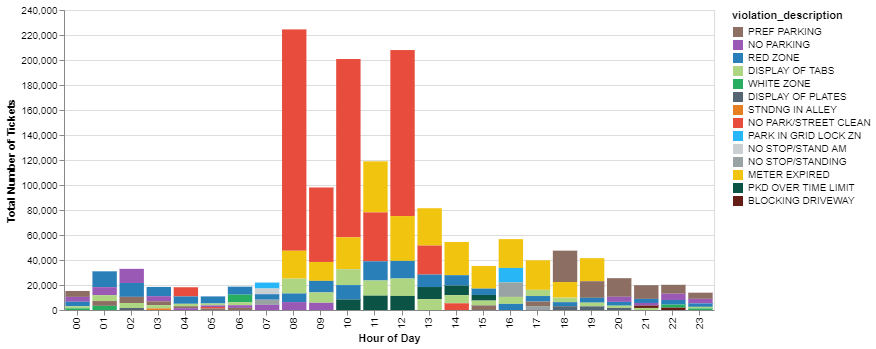

In [53]:
domain = list(chart4.violation_description.unique())
range_ = ['#8D6E63 ', '#9B59B6', '#2980B9','#AED581','#27AE60',
          '#566573','#E67E22', '#E74C3C', '#29B6F6', '#CACFD2', 
          '#99A3A4','#F1C40F', '#0B5345', '#641E16']

top_5_v_by_hour = alt.Chart(chart4).mark_bar().encode(
      alt.X('Issue time',type='ordinal',title='Hour of Day'),
      alt.Y('Ticket number',type='quantitative',title='Total Number of Tickets'),
      color=alt.Color('violation_description', scale=alt.Scale(domain=domain, range=range_)),
      order=alt.Order(
      'Ticket number',
      sort='ascending'
)).properties(width=650)

top_5_v_by_hour

# Violation Type analysis

Analysis was done to check the top 20 most frequent violations in LA and how much revenue was generated from them in 2018.

In [28]:
top_20_by_number = data.groupby('clean_v_code').agg({"Ticket number":"count",'Fine amount': 'sum'})\
                                    .reset_index().sort_values(by='Ticket number',ascending=False).head(20)
top_20_by_number['violation_description'] = top_20_by_number['clean_v_code'].map(get_violation_desc)
top_20_by_number['pct_of_total_tickets'] = top_20_by_number['Ticket number']/data.shape[0]
top_20_by_number['pct_of_total_tickets'] = top_20_by_number['pct_of_total_tickets'].map(lambda x: "{:.2%}".format(x))
top_20_by_number

,clean_v_code,Ticket number,Fine amount,violation_description,pct_of_total_tickets
140,8069BS,594541,43401493.0,NO PARK/STREET CLEAN,29.76%
174,8813B,295527,18618201.0,METER EXPIRED,14.79%
120,8056E4,166904,15521982.0,RED ZONE,8.35%
125,8058L,145586,9899853.0,PREF PARKING,7.29%
90,5204A-,123414,3085388.0,DISPLAY OF TABS,6.18%
139,8069B,92220,6732055.0,NO PARKING,4.62%
141,8069C,63344,3673952.0,PKD OVER TIME LIMIT,3.17%
84,5200,58525,1463125.0,DISPLAY OF PLATES,2.93%
117,8056E1,40720,2361760.0,WHITE ZONE,2.04%
138,8069AP,36856,3427595.0,NO STOP/STANDING,1.84%


In [29]:
avg_fine = data.groupby('clean_v_code').agg({"Ticket number":"count",'Fine amount': 'sum'})
avg_fine['Avg_Fine'] = avg_fine['Fine amount']/avg_fine['Ticket number']

In [346]:
total_20_fine = avg_fine.sort_values(by='Avg_Fine',ascending=False).reset_index().head(20)
total_20_fine['violation_description'] = total_20_fine['clean_v_code'].map(get_violation_desc)
total_20_fine

,clean_v_code,Ticket number,Fine amount,Avg_Fine,violation_description
0,22500L,9,3267.0,363.0,BLOCK HANDICAP ACCES
1,22522-,510,185130.0,363.0,3 FT. SIDEWALK RAMP
2,225078A,1823,661749.0,363.0,HANDICAP/NO DP ID
3,225078A-,6371,2312673.0,363.0,DISABLED PARKING/NO DP ID
4,225078B,57,20691.0,363.0,HANDICPD/BLOCKING
5,225078B-,149,54087.0,363.0,DISABLED PARKING/OBSTRUCT ACCESS
6,030,39,14157.0,363.0,22522
7,225078C1,173,62799.0,363.0,HANDICAP/ON LINE
8,225078C2,1399,507837.0,363.0,HANDICAP/CROSS HATCH
9,2251156B,27,9801.0,363.0,DP-REFUSE ID


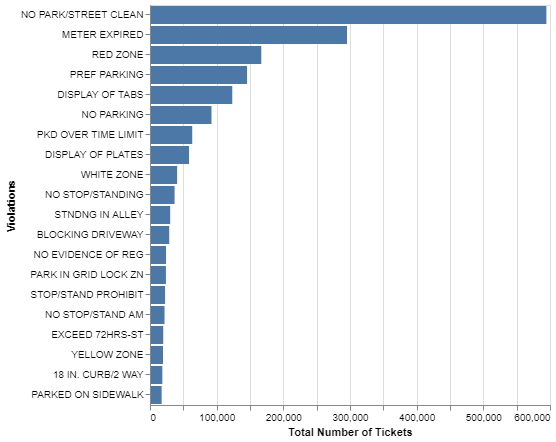

In [30]:
top_20_by_number = data.groupby('clean_v_code').agg({"Ticket number":"count",'Fine amount': 'sum'})\
                                    .reset_index().sort_values(by='Ticket number',ascending=False).head(20)
top_20_by_number['violation_description'] = top_20_by_number['clean_v_code'].map(get_violation_desc)
top_20_by_number['pct_of_total_tickets'] = top_20_by_number['Ticket number']/data.shape[0]
top_20_by_number['pct_of_total_tickets'] = top_20_by_number['pct_of_total_tickets'].map(lambda x: "{:.2%}".format(x))
top_20_by_number

top_violations = alt.Chart(top_20_by_number).mark_bar().encode(
    x=alt.X('Ticket number:Q', title='Total Number of Tickets'),
    y=alt.Y(
        'violation_description:N',
        title='Violations',
        sort=alt.EncodingSortField(
            field="Ticket number",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        )
    ),
    tooltip=['pct_of_total_tickets', 'Ticket number']
).interactive()
top_violations

# Agency Analysis 

In [177]:
agency_agg = data.groupby('Angency Name').agg({'Fine amount':'sum', "Ticket number" : "count"})\
.sort_values(by='Fine amount',ascending=False)
agency_agg['Fine Percentage'] = agency_agg['Fine amount']\
.map(lambda x: '{:.2%}'.format(x/data['Fine amount'].sum()))
agency_chart = agency_agg.reset_index()

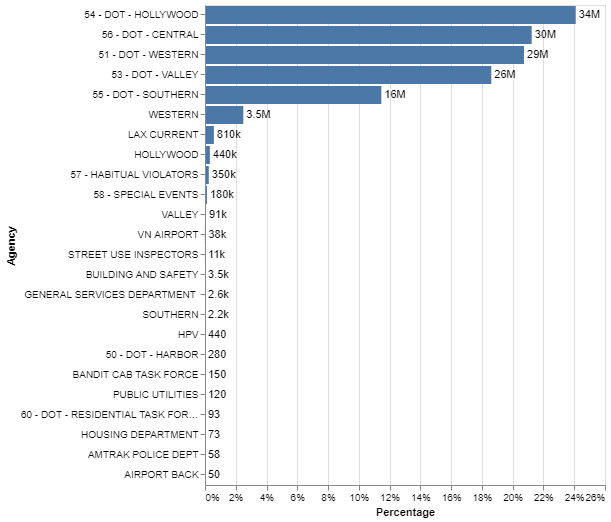

In [180]:
agency_chart.rename(columns={"Angency Name": "Agency", "Fine amount": "fine"},inplace=True)

bar = alt.Chart(agency_chart).transform_joinaggregate(
    TotalTime='sum(fine)',
).transform_calculate(
    PercentOfTotal="datum.fine / datum.TotalTime"
).mark_bar().encode(
    alt.X('PercentOfTotal:Q', axis=alt.Axis(format='.0%'),title='Percentage'),
    alt.Y('Agency:N', sort=alt.EncodingSortField(field='PercentOfTotal',order="descending")),
)


text = bar.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    alt.Text('fine:Q',format=(".2s"))
)

(bar + text)

In [ ]:
|